#Introduction to Graph Neural Networks with PyTorch

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# HOMEWORK 7

Perform node classification on the PubMed dataset to classify scientific publications into their respective categories. The PubMed dataset is a citation network among scientific publications. It consists of articles related to diabetes, with each article belonging to one of three categories: "Diabetes Mellitus Type 1" (class 0), "Diabetes Mellitus Type 2" (class 1), and "Diabetes Mellitus" (class 2).

# Install required packages.


In [37]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.2.1+cu121
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


#Load the dataset

In [38]:
from torch_geometric.datasets import Planetoid

# Load the Cora dataset
dataset = Planetoid(root='data/Planetoid', name='PubMed')

# Print dataset information
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)


Dataset: PubMed():
Number of graphs: 1
Number of features: 500
Number of classes: 3

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])


**Define a GCN network**


In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(self, input_dim, output_dim, params):
        super(GCN, self).__init__()
        self.num_layers = params['num_layers']
        self.hidden_channels = params['hidden_channels']
        self.dropout_rate = params['dropout']

        # Define the GCN layers based on num_layers
        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(input_dim, self.hidden_channels))

        for _ in range(self.num_layers - 2):
            self.convs.append(GCNConv(self.hidden_channels, self.hidden_channels))

        self.convs.append(GCNConv(self.hidden_channels, output_dim))
        self.dropout = nn.Dropout(self.dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = torch.relu(x)
            x = self.dropout(x)

        x = self.convs[-1](x, edge_index)
        return x


**Visualize the node embeddings of the untrained GCN network using PCA (or t-SNE if you are or want to get familiar with it)**

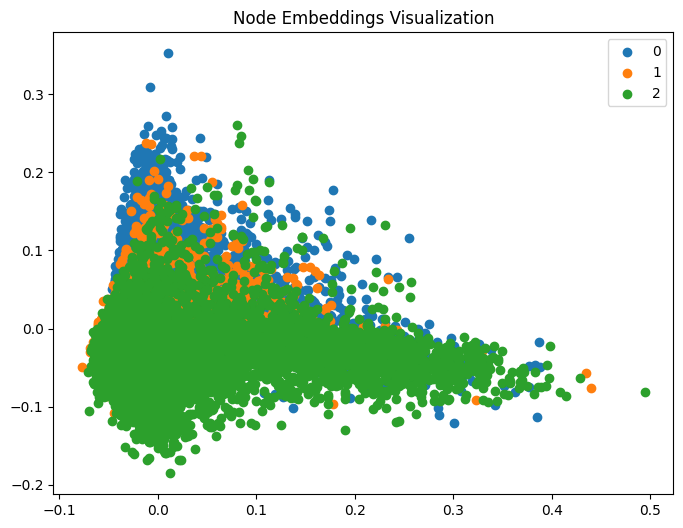

In [40]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def visualize_embeddings(embeddings, labels):
    pca = PCA(n_components=2)
    embeddings_pca = pca.fit_transform(embeddings.detach().numpy())

    plt.figure(figsize=(8, 6))
    for i in range(len(labels.unique())):
        indices = np.where(labels == i)[0]
        plt.scatter(embeddings_pca[indices, 0], embeddings_pca[indices, 1], label=str(i))
    plt.legend()
    plt.title('Node Embeddings Visualization')
    plt.show()

# Assuming 'data' contains the graph data
visualize_embeddings(data.x, data.y)


**Perform a grid search hyperparameter tuning for the following parameters:**
- Number of Layers
- Hidden Dimension Size
- Learning Rate
- Dropout Rate
- Batch Size

PS: Remember, first you need to split the data into training, validation and test sets.

In [41]:
from torch_geometric.data import DataLoader
from sklearn.model_selection import ParameterGrid, train_test_split
import itertools

# Extract samples from the dataset
data_list = [dataset[i] for i in range(len(dataset))]
sample_data = data_list[0]  # Get the first sample

# Define hyperparameters to search over
params_grid = {
    'num_layers': [2, 3, 4],
    'hidden_channels': [64, 128],
    'dropout': [0.2, 0.3,0.5],
    'lr': [0.01, 0.001,0.0001],
    'batch_size': [300,1000]
}

# Define training parameters
num_epochs = 5
best_val_acc = 0
best_params = None

# Iterate over all hyperparameter combinations
for params in ParameterGrid(params_grid):
    # Initialize model
    model = GCN(sample_data.num_features, dataset.num_classes, params)

    # Define optimizer and criterion
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    criterion = torch.nn.NLLLoss()

    # Training loop
    for epoch in range(1, num_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(sample_data)
        loss = criterion(out[sample_data.train_mask], sample_data.y[sample_data.train_mask])
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        out = model(sample_data)
        pred = out.argmax(dim=1)
        correct = pred[sample_data.test_mask].eq(sample_data.y[sample_data.test_mask]).sum().item()
        val_acc = correct / sample_data.test_mask.sum().item()

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_params = params

print("Best validation accuracy:", best_val_acc)
print("Best parameters:", best_params)

Best validation accuracy: 0.727
Best parameters: {'batch_size': 1000, 'dropout': 0.2, 'hidden_channels': 128, 'lr': 0.01, 'num_layers': 2}


**Train the GCN model with the optimal hyperparameters**
 - Select the best model based on the highest validation performance (lowest validation loss).*italicized text*
 - Save the best model to load it later for the final evaluation process.

In [42]:
best_model = GCN(sample_data.num_features, dataset.num_classes, best_params)
optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params['lr'])
criterion = torch.nn.NLLLoss()

for epoch in range(num_epochs):
    best_model.train()
    optimizer.zero_grad()
    out = best_model(sample_data)
    loss = criterion(out[sample_data.train_mask], sample_data.y[sample_data.train_mask])
    loss.backward()
    optimizer.step()
torch.save(best_model.state_dict(), 'best_gcn_model.pt')

**Visualize the output embeddings of your trained model. What do you observe?**

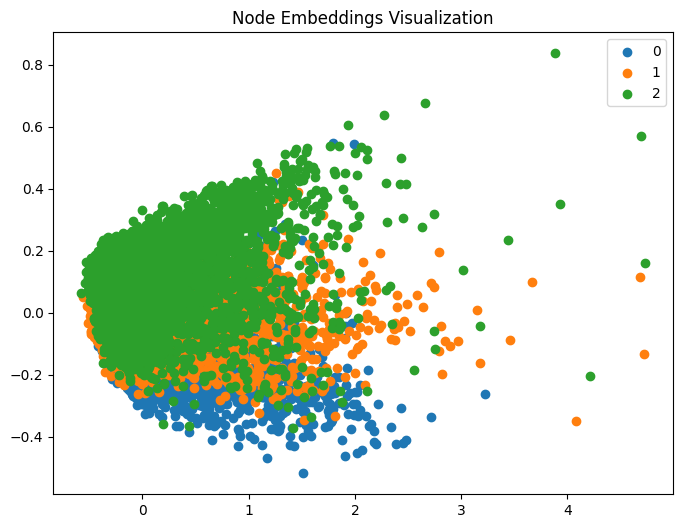

In [43]:
embeddings = best_model(sample_data).detach()
labels = sample_data.y

# Visualize embeddings
visualize_embeddings(embeddings, labels)

**Evaluate the trained model on the test set and report the classification accuracy**

In [44]:
# Set the model to evaluation mode
best_model.eval()

# Pass the test data through the model
with torch.no_grad():
    out = best_model(sample_data)
    pred = out.argmax(dim=1)

# Compare predictions with ground truth labels for the test set
test_correct = pred[sample_data.test_mask].eq(sample_data.y[sample_data.test_mask]).sum().item()

# Calculate classification accuracy
test_accuracy = test_correct / sample_data.test_mask.sum().item()

# Report the classification accuracy
print("Test accuracy:", test_accuracy)

Test accuracy: 0.251
